<a href="https://colab.research.google.com/github/sosoihd/TP_ML/blob/main/TP3_Audio_V9_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from IPython.display import display, Audio
import matplotlib.pyplot as plt
#from scipy.io.matlab import mio
from scipy.io import wavfile as wf
from numpy.fft import fft
from scipy import signal
import cmath as cm

*Mes Fonctions :*

In [ ]:
def AnalyseSpectrale(x,Fe,M,holdOn=1,AffichageSeulement=0,bornex = 0,borney = 0):

  if bornex == 0 : bornex =  [-Fe/2 ,Fe/2]
  # Axe des frequences          
  freq=np.fft.fftfreq(len(x))*Fe


  if (AffichageSeulement==1):
    if holdOn == 1:
      plt.figure(figsize=(12,6))
    plt.suptitle('Spectre d''Amplitude du signal')
    plt.plot(np.fft.fftshift(freq),np.fft.fftshift(x))
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (u.a.)')
    plt.xlim(bornex);
    if borney !=0  : plt.ylim(borney);
    plt.grid()
    if holdOn == 0:
      plt.grid()
      plt.show()

  else:
    # transformée de fourier           
    tfd = np.fft.fft(x)

    # Spectre d'amplitude
    spectre = np.abs(tfd)
    if holdOn == 1:
      plt.figure(figsize=(12,6))
    plt.suptitle('Spectre d''Amplitude du signal')
    plt.plot(np.fft.fftshift(freq),np.fft.fftshift(spectre))
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (u.a.)')
    plt.grid()
    plt.xlim(bornex); 
    if borney !=0  : plt.ylim(borney);
    if holdOn == 0:
      plt.grid()
      plt.show()

In [ ]:
def AnalyseTemporelle(x,t,holdOn=1):
  if holdOn == 1:
    plt.figure(figsize=(12,6))
  plt.plot(t,x)
  plt.grid()
  plt.xlabel('Temps (t)')
  plt.ylabel('Amplitude(v)')
  plt.title("Allure temporelle du signal")
  if holdOn == 0:
    plt.grid()
    plt.show()

In [ ]:
def Spectrogramme(xMat,t,F):
  # On parcourt xMat pour trouver les valeurs qui sont à 0 
  # On change ces valeurs pour eviter la division par 0 dans la fonction log10()
  for i in range (0,np.size(xMat,1),1):
    for j in range (0,np.size(xMat,0),1):
      if (xMat[j,i]==0):
        xMat[j,i] = 0.00000001
        
  plt.figure(figsize=(12,6))
  plt.suptitle('Spectrogramme du signal')
  plt.imshow(20*np.log10(xMat),extent=(t[0],t[-1],np.amin(F),np.amax(F)),aspect='auto')
  plt.xlabel("Temps(s)")
  plt.ylabel("Frequence(Hz)")

*Transformée de Fourier à court-terme :*

In [ ]:
def tftct(soundName,Nwin,Nhop,Nfft,lectureSon=1):
  """
  soundName = Nom du fichier audio  " nomDuFichier.wav "
  Nwin = taille de la fenetre d'analyse
  Nhop = pas d'avancement de la fenetre d'analyse
  Nfft = nombre de points frequentiels utilises pour la fft
  """
  # Chargement du son
  Fe, x = wf.read(soundName)
  if (lectureSon == 1):
    # Pour ecouter le son 
    display(Audio(x,rate=Fe))
  
  # cast des parametres + tests 
  if (Nwin > np.size(x,0)):
    Nwin = np.size(x,0)
  Nhop = int(Nhop)

  # Generer une fenetre hamming de largeur M=Nwin
  window = np.hamming(Nwin)
  xVect=[]

  # 1 - Découpage du signal audio en trames de Nwin fenetres 
  for i in range (0,np.size(x,0),Nhop):
    if (i+Nwin > np.size(x,0)):
      break
    xVect.append(x[i:i+Nwin]*window)

  xVect=np.array(xVect)
  xVect=xVect.T


  # 2 - TFD de la trame sur Nfft points 
  # transformée de fourier
  tfd_xVect=[]
  xMat=[]
  for i in range (0,np.size(xVect,1),1):           
    tfd_xVect.append(np.fft.fft(xVect[:,i],n=Nfft))

  tfd_xVect=np.array(tfd_xVect)
  tfd_xVect=tfd_xVect.T
  for i in range (0,np.size(tfd_xVect,1),1):
    # Spectre d'amplitude
    xMat.append(np.abs(tfd_xVect[:,i]))

  xMat=np.array(xMat)
  xMat=xMat.T
  
  return [x,tfd_xVect,xMat , Fe]

## 3.1 Implémentation de la TFCT inverse par Overlapp-Add (OLA)

In [ ]:
def itftct(xMat,Nwin,Nhop):
  """
  xMat = Tftct du signal 
  Nwin = taille de la fenetre d'analyse
  Nhop = pas d'avancement de la fenetre d'analyse
  """
  #nombre de colonne 
  L = int(xMat.shape[1])

  #nombre de ligne de y
  Nfft = int(xMat.shape[0])
  N = int(Nfft + (L-1)*Nhop)
  #Generer une matrice y de transformée inverse 
  y = np.zeros([Nfft,L])

  #Génerer un vecteur de zeros 
  #z = np.zeros([1,Nfft])
  z = np.zeros([Nfft])

  #initialiser le vecteur yVect
  yVect = np.zeros([N])

  # 1 - ITFTCT et Récuperation des L trames 
  for i in range (0,L):
    #y[i,0:Nfft] = np.fft.ifft(xMat[:,i],Nfft)
    y[:,i] = np.real(np.fft.ifft(xMat[:,i],Nfft))

  # 2 - décalage + somme des trames 
  for n,i in enumerate(range(0, N-Nwin, Nhop)):
    yVect[i:i+Nwin] += y[:,n]
  # Generer une fenetre hamming de largeur Nwin
  window = np.hamming(Nwin)
  yWin_mat = np.zeros([Nwin,L])

  # 1 - On remplit chaque colonne de yWin_mat avec une fenêtre
  for i in range (0,L,1):
    yWin_mat[:,i] = window
  # 2 - On effectue le décalage + somme des trammes 
  yWin_vect=np.zeros([N])
  for n,i in enumerate(range(0, N-Nwin, Nhop)):
    yWin_vect[i:i+Nwin] += yWin_mat[:,n]
  # 3 - On divise yVect par yWin_Vect
  
  for i in range(0,N,1):
    if(yWin_vect[i] ==0): # pour eviter la division sur 0
      continue
    yVect[i] = yVect[i]/yWin_vect[i]
  

  #Vecteur temps t 
  t=np.arange(0,np.size(yVect,0))

  return [yVect,t]

### Test sur le Signal sound.wav

In [ ]:
Nwin = 1024
Nhop = 512
Nfft = Nwin
# On applique la TFCTC :
[x, xVect, xMat, Fe] = tftct("sound.wav",Nwin,Nhop,Nfft)
print('fréquence d"echantillonnage : ',Fe)

fréquence d"echantillonnage :  16000


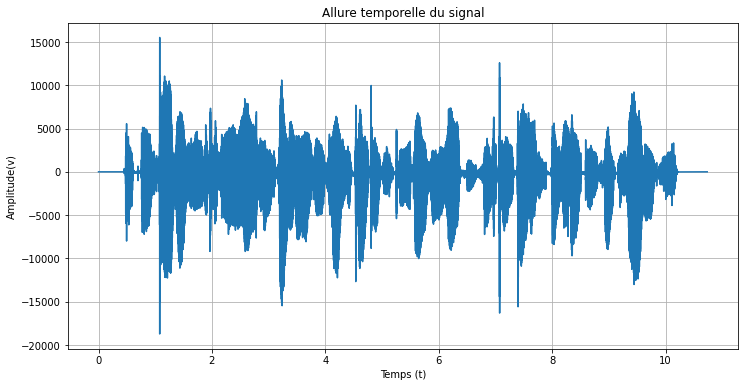

In [ ]:
t=np.arange(0,np.size(x,0),1)/Fe
AnalyseTemporelle(x,t,1)
#plt.xlim(0,0.5)

*Application de la Transformée inverse :*

In [ ]:
# On applique la TFCTC inverse :
[yVect,t_y]= itftct(xVect,Nwin,Nhop)

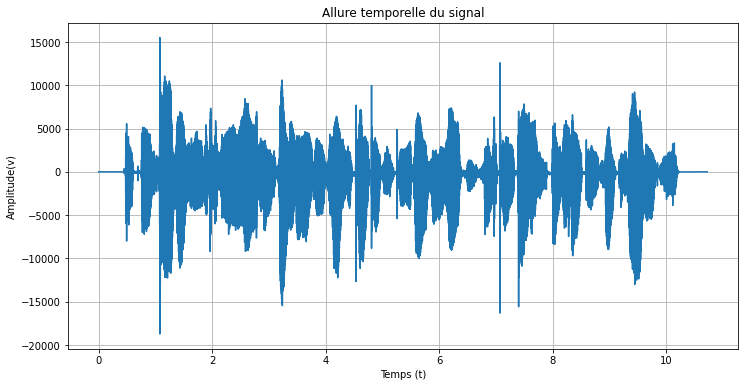

In [ ]:
AnalyseTemporelle(yVect,t_y/Fe,1)
display(Audio(yVect,rate=Fe))


**Commentaire :** 
A l'écoute, le signal audio reconstruit à l'aire d'être le même que le signal d'origine.

*On superpose les 2 Signaux Original et reconstruit :*

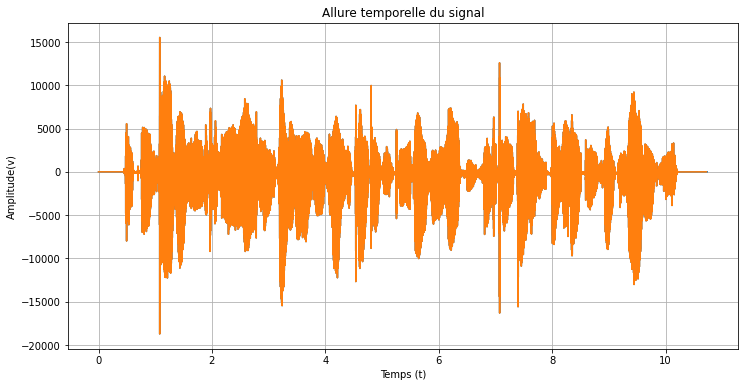

In [ ]:

AnalyseTemporelle(x,t,1) # Signal original en bleu
#plt.xlim(0,1)
AnalyseTemporelle(yVect,t_y/Fe,holdOn=0)
#plt.xlim(0,1)

**Commentaire :**
Le signal recomposé est identique au signal d'origine. 

l n'y a pas eu de perte d'informations.

## 3.2 Application au débruitage pour soustraction spectrale:

###3.2.7 Calcul de la TFCT du signal mix.wav :

In [ ]:
Nwin_m = 512
Nhop_m = 128
Nfft_m = Nwin_m

# On applique la TFCT
[x_m, xVect_m, xMat_m, Fe_m] = tftct("mix.wav",Nwin_m,Nhop_m,Nfft_m)
print('fréquence d"echantillonnage : ',Fe_m)


fréquence d"echantillonnage :  16000


Spectrogramme de |X| :

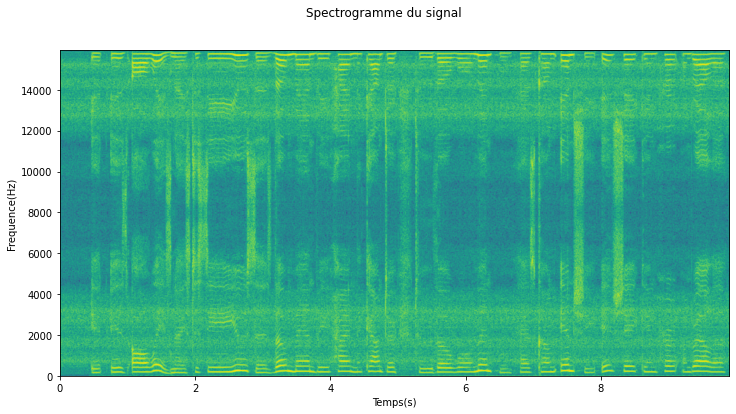

In [ ]:
Spectrogramme(xMat_m,t=(np.arange(0,np.size(x_m,0),1)/Fe_m),F=np.arange(0,Nfft_m)*(Fe_m/Nfft_m))

**Commentaire :** On voit bien qu'on a que du bruit de fond au début du signal sur environs 0.5 secondes .

*Zoom sur la partie où on a que du bruit :*

(0.0, 7680.0)

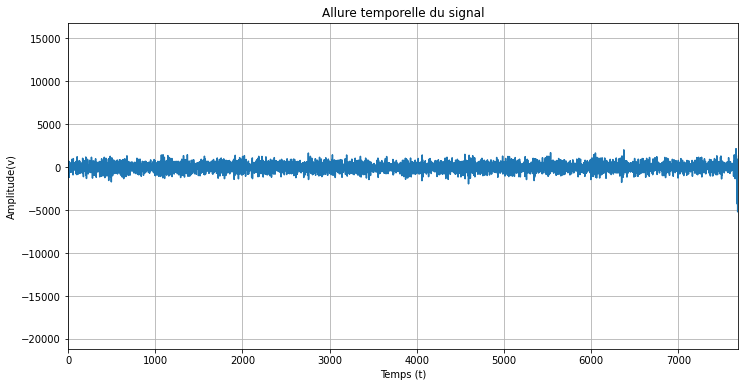

In [ ]:
t_m=np.arange(0,np.size(x_m,0),1)
AnalyseTemporelle(x_m,t_m,1)

plt.xlim(0,7680)

**Commentaire :** Ce zoom nous permet de voir sur quelle largeur on n'a que du bruit. 

On prend une fenêtre courte d'analyse pour observer précisément les temps.

###3.2.8 Spectre d'amplitude du bruit |Xnoise| :

Dans notre cas le spectre d'amplitude du bruit |Xnoise| correspond aux1 ères colonnes de xMat_m 

Si on affiche par exemple les spectres des 2 premières trames on voit que les spectres se ressemblent, sachant qu'on est parti de la théorie que notre bruit est stationnaire, les spectres sont sensés êtres identiques.

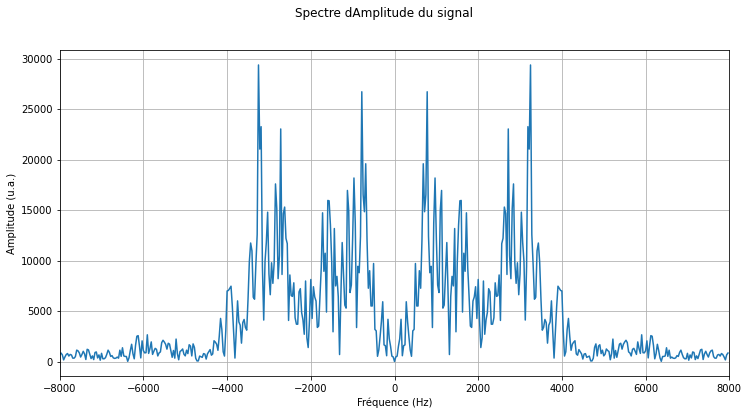

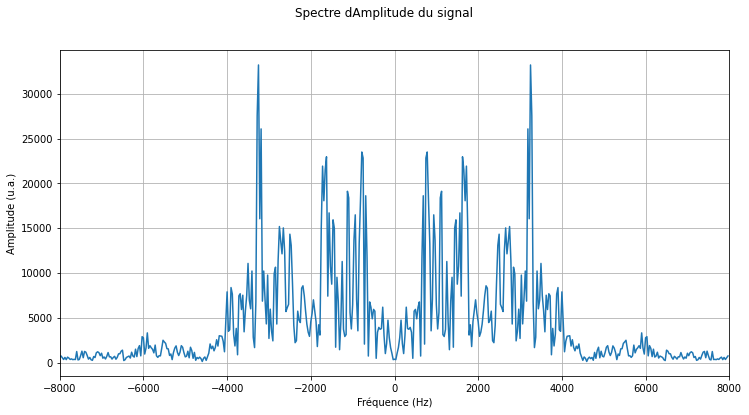

In [ ]:
AnalyseSpectrale(xMat_m[:,0],Fe_m,Nfft_m,AffichageSeulement=1,holdOn=1)
AnalyseSpectrale(xMat_m[:,1],Fe_m,Nfft_m,AffichageSeulement=1,holdOn=1)

On superpose les 2 spectres :

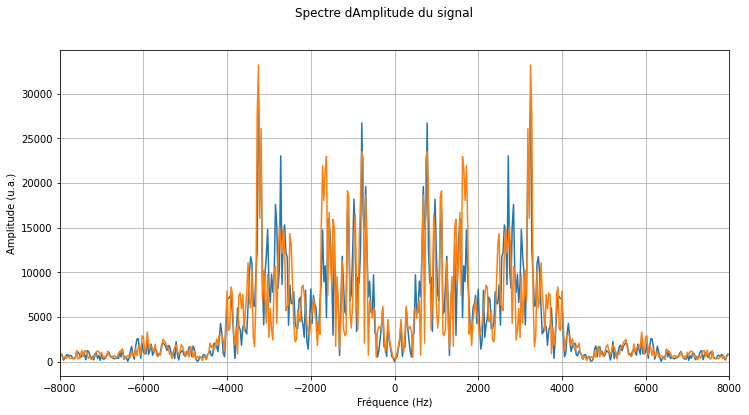

In [ ]:
AnalyseSpectrale(xMat_m[:,0],Fe_m,Nfft_m,AffichageSeulement=1,holdOn=1)
AnalyseSpectrale(xMat_m[:,1],Fe_m,Nfft_m,AffichageSeulement=1,holdOn=0)


**Commentaire :** On constate que les spectres ne sont pas identiques en tout point, c'est tout à fait normale car on a juste supposé que notre bruit est stationnaire mais il ne l'est pas complètement. 

###3.2.9 Estimation du spectrogramme du signal débruité |Xclean| :

On va faire une soustraction spectrale : 
|Xclean| = |X| - |Xnoise|

In [ ]:
mod_xClean = np.zeros([np.size(xMat_m,0),np.size(xMat_m,1)])

for i in range (0,np.size(xVect_m,1),1):
  for j in range (0,np.size(xVect_m,0),1):
    soustraction = xMat_m[j,i] - xMat_m[j,0]    
    if soustraction <= 0 :
      soustraction = 0 
    mod_xClean[j,i] = soustraction



**Commentaire :** On a veillé à redresser les valeurs négatives après soustraction à la valeur 0 car il ne faut pas oublier qu'on travaille avec les modules et ils ne peuvent as êtres négatifs.

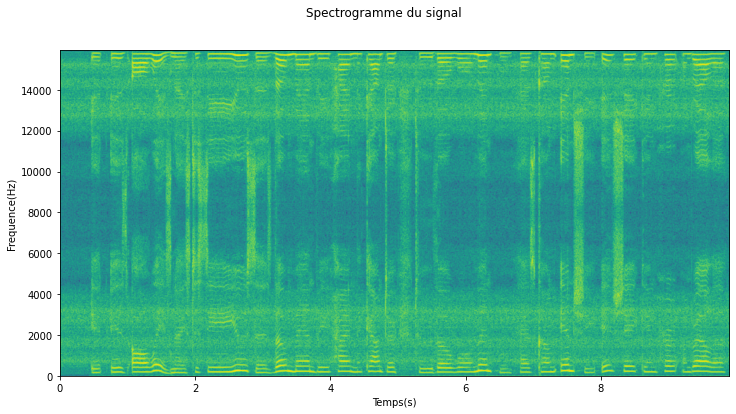

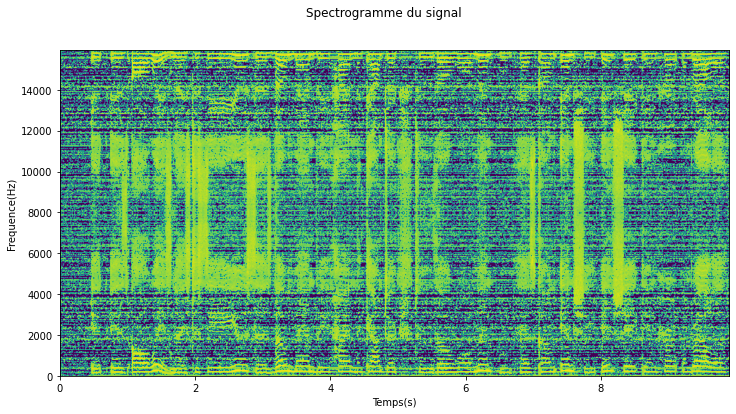

In [ ]:
# Spectrogramme Avant soustraction
Spectrogramme(xMat_m,t=(np.arange(0,np.size(x_m,0),1)/Fe_m),F=np.arange(0,Nfft_m)*(Fe_m/Nfft_m))
# Spectrogramme aprés soustraction
Spectrogramme(np.absolute(mod_xClean),t=(np.arange(0,np.size(x_m,0),1)/Fe_m),F=np.arange(0,Nfft_m)*(Fe_m/Nfft_m))

**Commentaire :** On constate que le bruit à été attenué mais il n'a pas été completement supprimé.

###3.2.11 Reconstruction du signal audio débruité :

In [ ]:
# Avec seulement |Xclean| :
[xClean_1,t_xClean_1]= itftct(mod_xClean,Nwin_m,Nhop_m)
display(Audio(xClean_1,rate=Fe_m))

*Affichage du signal reconstruit :*

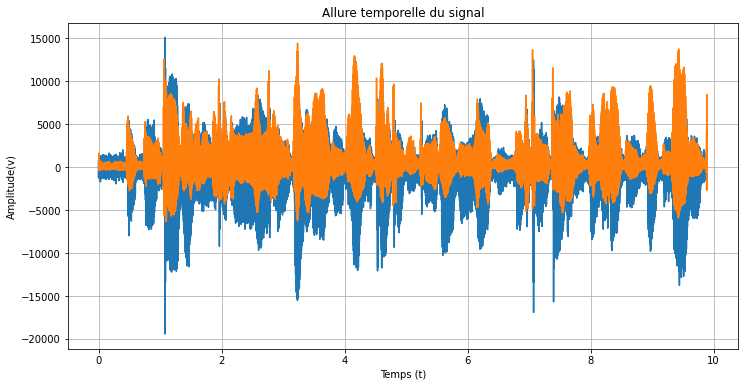

In [ ]:
AnalyseTemporelle(x_m,t_m/Fe_m,1)
AnalyseTemporelle(xClean_1,t_xClean_1/Fe_m,0)

**Commentaire :** On ne peut pas reconstruire notre signal à partir d'un module car il nous manque l'information sur la phase qui va nous permettre de bien placer nos sinusoïdes.

On constate que le signal reconstruit est totalement différent du signal d'origine et à l'écoute on a une voix robotisée.

###3.2.12 Rencostruction du signal audio à partir du spectre complexe :

In [ ]:
# Passage du module au spectre complexe :

# Calcul de la Phase de chaque trame de xVect
 
Phi_x = np.zeros([np.size(xVect_m,0),np.size(xVect_m,1)])

for i in range (0,np.size(xVect_m,1),1):
  Phi_x[:,i] = np.angle(xVect_m[:,i])

# Calcul de xVect à partir du module (XMat_m) et de la phase (Phi_x)
xClean_comp=np.zeros([np.size(mod_xClean,0),np.size(mod_xClean,1)],dtype='complex')

for i in range (0,np.size(mod_xClean,1),1):
  for j in range (0,np.size(mod_xClean,0),1):
    xClean_comp[j,i] = cm.rect(mod_xClean[j,i],Phi_x[j,i])

# Avec le spectre complexe :
[xClean_2,t_xClean_2]= itftct(xClean_comp,Nwin_m,Nhop_m)


*Affichage du signal reconstruit :*

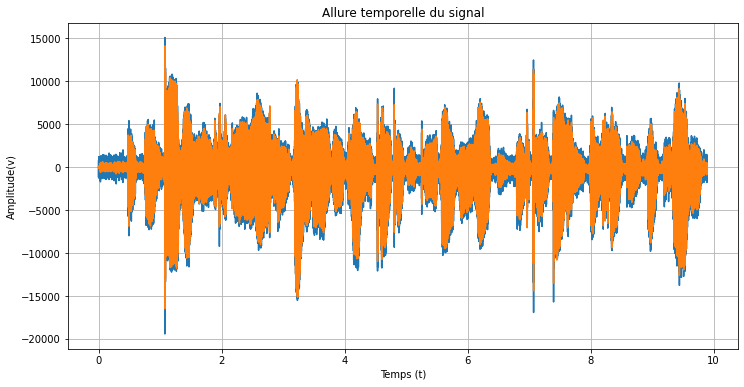

In [ ]:
AnalyseTemporelle(x_m,t_m/Fe_m,1)
AnalyseTemporelle(xClean_2,t_xClean_2/Fe_m,0)

**Commentaire :** l'ajout de la phase nous a permis de reconstruire convenablement notre signal.

Tandis que le module nous donne l'amplitude, la phase nous permet de positionner nos sinusoïdes pour bien restituer notre signal audio.

###3.2.13 Jugement à l'écoute :

In [ ]:
print("Signal avant soustraction : ")
display(Audio(x_m,rate=Fe_m))
print("Signal aprés soustraction : ")
display(Audio(xClean_2,rate=Fe_m))

Signal avant soustraction : 


Signal aprés soustraction : 


**Commentaire :** On constate que le bruit a été attenué comme on l'a vu précédemment sur le spectrogramme. 

Le bruit n'a pas été complétement supprimé car comme on l'a dit précédemment, on a juste supposé que ce bruit était stationnaire mais en réalité il ne l'est pas.

Nous avons essayé de travailler avec des fenêtres de différentes tailles et des sauts différents mais les résultats n'étaient pas concluents.

###3.2.14 Mesure des RSB :

In [ ]:
# 1 - il nous faut le signal propre :
Fe_sound, x_sound = wf.read("sound.wav")


# Calcul de l'ecart type
sig_x_sound = np.std(x_sound)

# Calcul de la variance
var_x_sound = sig_x_sound**2


# 2 - le signal bruitée mix.wav

Eq_x_m =x_m - x_sound[0:len(x_m)] # Le signal x_sound est plus grand que x_m 
# Calcul de l'ecart type
sig_Eq_x_m = np.std(Eq_x_m)

# Calcul de la variance
var_Eq_x_m = sig_Eq_x_m**2

# 3 - le signal apés supression du bruit

Eq_xClean_2 =xClean_2 - x_sound[0:len(xClean_2)] # Le signal x_sound est plus grand que xClean_2 
# Calcul de l'ecart type
sig_Eq_xClean_2 = np.std(Eq_xClean_2)

# Calcul de la variance
var_Eq_xClean_2 = sig_Eq_xClean_2**2

RSB_avant = var_x_sound/var_Eq_x_m

RSB_apres = var_x_sound/var_Eq_xClean_2


print("RSB Avant supression du bruit : ",10*np.log10(RSB_avant)," db")
print("RSB Aprés supression du bruit : ",10*np.log10(RSB_apres)," db")

RSB Avant supression du bruit :  13.108307659967045  db
RSB Aprés supression du bruit :  16.980364678458223  db


**Commentaire :** Le calcul du RSB montre bien que le bruita été atténué d'environs 4db .  Cela reste peu et montre que cette méthode n'est pas très performante.